# Lab 1 - Data

This activity is designed to test your skills in generating synthetic datasets, handling real-world data challenges, and preparing data to be fed into neural networks.



### Exercise 1 - Exploring Class Separability in 2D

generate and visualize a two-dimensional dataset to explore how data distribution affects the complexity of the decision boundaries a neural network would need to learn.

Generate the Data: Create a synthetic dataset with a total of 400 samples, divided equally among 4 classes (100 samples each). Use a Gaussian distribution to generate the points for each class based on the following parameters:

- Class 0: Mean = [2,3] , Standard Deviation = [0.8,2.5]
- Class 1: Mean = [5,6], Standard Deviation = [1.2,1.9]
- Class 2: Mean = [8,1], Standard Deviation = [0.9,0.9]
- Class 3: Mean = [15,4], Standard Deviation = [0.5,2.0]


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [ ]:
rng = np.random.default_rng(42)

params = {
    0: {"mean": np.array([2.0, 3.0]), "std": np.array([0.8, 2.5])},
    1: {"mean": np.array([5.0, 6.0]), "std": np.array([1.2, 1.9])},
    2: {"mean": np.array([8.0, 1.0] ), "std": np.array([0.9, 0.9])},
    3: {"mean": np.array([15.0, 4.0]), "std": np.array([0.5, 2.0])},
}

n_samples_class = 100

data_list = []
for cls, p in params.items():
    samples = rng.normal(loc=p["mean"], scale=p["std"], size=(n_samples_class, 2))
    labels = np.full((n_samples_class, 1), cls, dtype=int)
    data_list.append(np.hstack([samples, labels]))

# Combine
data = np.vstack(data_list)
df = pd.DataFrame(data, columns=["x1", "x2", "label"]).astype({"label": int})

# Shuffle rows
df = df.sample(frac=1.0, random_state=123).reset_index(drop=True)

# Save to CSV
csv_path = "synthetic_gaussian_4class_400.csv"
df.to_csv(csv_path, index=False)

# Show class counts
counts = df["label"].value_counts().sort_index()

# Display a preview to the user
df.head(500)


,x1,x2,label
0,8.995394,0.134118,2
1,1.043328,4.217431,0
2,15.381463,4.896199,3
3,6.412894,6.834265,1
4,14.782296,3.041794,3
...,...,...,...
395,8.282517,0.249968,2
396,2.514661,2.013487,0
397,14.831337,3.715994,3
398,15.170396,0.432778,3


##### Plot the Data 

Create a 2D scatter plot showing all the data points. Use a different color for each class to make them distinguishable.

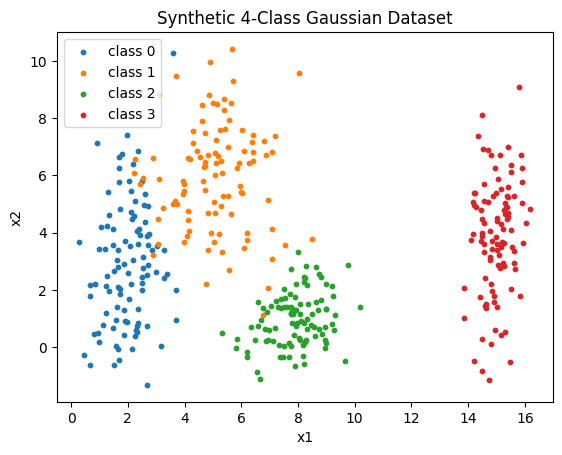

In [66]:
plt.figure()
for cls in sorted(params.keys()):
    subset = df[df["label"] == cls]
    plt.scatter(subset["x1"], subset["x2"], label=f"class {cls}", s=10)
plt.title("Synthetic 4-Class Gaussian Dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


##### Analyze and Draw Boundaries

- Examine the scatter plot carefully. Describe the distribution and overlap of the four classes.
- Based on your visual inspection, could a simple, linear boundary separate all classes?
- On your plot, sketch the decision boundaries that you think a trained neural network might learn to separate these classes.

In [67]:
bounds = df.groupby("label").agg(
    min_x=("x1", "min"),
    max_x=("x1", "max"),
    min_y=("x2", "min"),
    max_y=("x2", "max"),
).reset_index()

bounds

,label,min_x,max_x,min_y,max_y
0,0,0.294363,3.713318,-1.318301,10.284656
1,1,2.227876,8.486081,1.123349,10.422541
2,2,5.331924,10.178374,-1.100255,3.337906
3,3,13.839822,16.191301,-1.129489,9.098656


- Class 0 (mean [2,3], elongated vertically, slight spread horizontally)
  - Class 0 is spread more in the vertical direction. It also has a slight spread horizontally.
  - The minimum and maximum values of the points in Class 0 are: 
    - min_x: 0.294363
    - max_x: 3.713318
    - min_y: -1.318301
    - max_y: 10.284656
  - As such, it's points form a tall, narrow cluster near the lower-left corner.

- Class 1 (mean [5,6], larger spread horizontally and vertically)
  - Centered above Class 0 and class 2, to the left of Class 0 and to the right of Class 2, it has the largest horizontal spread.
  - The minimum and maximum values of the points in Class 1 are: 
    - min_x: 2.227876
    - max_x: 8.486081
    - min_y: 1.123349
    - max_y: 10.422541
  - Its cluster overlaps somewhat in vertical extent with Class 0.
  - Does not appear to have a distinguished shape

- Class 2 (mean [8,1], compact "round" cluster)
  - This class is tighter (std = [0.9, 0.9]) and appears in the bottom-middle region.
  - Class 2 doesn’t overlap much with Classes 0 or 1 because it’s horizontally farther away and has limited vertical amplitude.
  - The minimum and maximum values of the points in Class 1 are: 
    - min_x: 5.331924
    - max_x: 10.178374
    - min_y: -1.100255
    - max_y: 3.337906
  - Limited amplitudes horizontally and vertically create "rounded" appearance of cluster

- Class 3 (mean [15,4], elongated horizontally)
  - Very far to the right, centered at x ≈ 15, with std = [0.5, 2.0].
  - Does not overlap with any of the other classes.
  - As such, it forms a tall, narrow vertical band, to the far right of the plot.
  - The minimum and maximum values of the points in Class 1 are: 
    - min_x: 13.839822	
    - max_x: 16.191301
    - min_y: -1.129489
    - max_y: 9.098656

Because some overlap is seen between classes, a linear boundary will not separate each class perfectly, producing a few outliers in the process. With that being said, each Class significantly occupies a unique region in the graph. As such, disregarding outliers, a designating a linear boundary is possible


In [68]:
#identify min x for each class, subtracting std deviation to each value

min_x_0 = bounds.loc[bounds["label"] == 0, "min_x"].values[0] + params[0]["std"][0]
min_x_1 = bounds.loc[bounds["label"] == 1, "min_x"].values[0] + params[1]["std"][0]
min_x_2 = bounds.loc[bounds["label"] == 2, "min_x"].values[0] + 5*params[2]["std"][0]
min_x_3 = bounds.loc[bounds["label"] == 3, "min_x"].values[0] - 5*params[3]["std"][0]

#identify max x for each class, adding std deviation to each value

max_x_0 = bounds.loc[bounds["label"] == 0, "max_x"].values[0] + params[0]["std"][0]
max_x_1 = bounds.loc[bounds["label"] == 1, "max_x"].values[0] + params[1]["std"][0]
max_x_2 = bounds.loc[bounds["label"] == 2, "max_x"].values[0] + params[2]["std"][0]
max_x_3 = bounds.loc[bounds["label"] == 3, "max_x"].values[0] - 2*params[3]["std"][0]

#identify min y for each class, subtracting std deviation to each value

min_y_0 = bounds.loc[bounds["label"] == 0, "min_y"].values[0] - params[0]["std"][1]
min_y_1 = bounds.loc[bounds["label"] == 1, "min_y"].values[0] - params[1]["std"][1]
min_y_2 = bounds.loc[bounds["label"] == 2, "min_y"].values[0] - params[2]["std"][1]
min_y_3 = bounds.loc[bounds["label"] == 3, "min_y"].values[0] - params[3]["std"][1]

#identify max y for each class, adding std deviation to each value

max_y_0 = bounds.loc[bounds["label"] == 0, "max_y"].values[0] + params[0]["std"][1]
max_y_1 = bounds.loc[bounds["label"] == 1, "max_y"].values[0] - 2*params[1]["std"][1]
max_y_2 = bounds.loc[bounds["label"] == 2, "max_y"].values[0] + 5*params[2]["std"][1]
max_y_3 = bounds.loc[bounds["label"] == 3, "max_y"].values[0] + params[3]["std"][1]

max_y_0, min_x_2, max_x_3, min_y_1

(np.float64(12.784656165018324),
 np.float64(9.831924045942515),
 np.float64(15.191301141342038),
 np.float64(-0.7766510377694646))

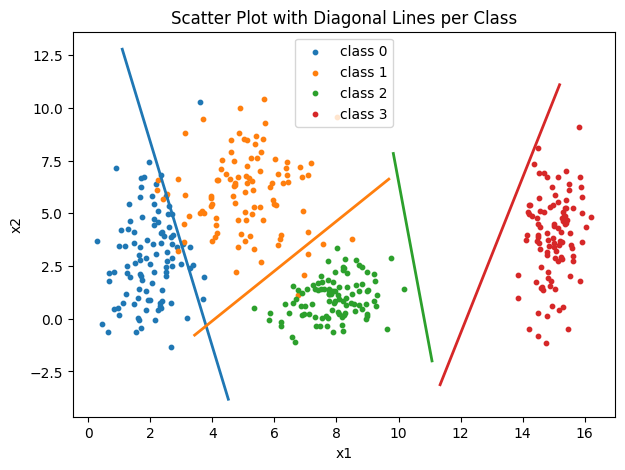

In [69]:
stds = df.groupby("label").agg(std_x=("x1","std"), std_y=("x2","std")).reset_index()

# Merge bounds and stds
bounds_std = bounds.merge(stds, on="label")

# Scatter plot of all points
plt.figure(figsize=(7,5))
for cls in sorted(df["label"].unique()):
    subset = df[df["label"] == cls]
    plt.scatter(subset["x1"], subset["x2"], label=f"class {cls}", s=10)

# Add diagonal lines using bounds
plt.plot([min_x_0, max_x_0], [max_y_0, min_y_0], linewidth=2)
plt.plot([min_x_1, max_x_1], [min_y_1, max_y_1], linewidth=2)
plt.plot([min_x_2, max_x_2], [max_y_2, min_y_2], linewidth=2)
plt.plot([min_x_3, max_x_3], [min_y_3, max_y_3], linewidth=2)

plt.title("Scatter Plot with Diagonal Lines per Class")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


### Excercise 2 - Non-Linearity in Higher Dimensions

Deep networks excel when data is not linearly separable. This exercise challenges you to create and visualize such a dataset.

Generate the Data: Create a dataset with 500 samples for Class A and 500 samples for Class B. Use a multivariate normal distribution with the following parameters:



In [70]:
# --- Parameters ---
mean_A = np.array([0, 0, 0, 0, 0], dtype=float)
cov_A = np.array([
    [1,   0.8, 0.1, 0.0, 0.0],
    [0.8, 1.0, 0.3, 0.0, 0.0],
    [0.1, 0.3, 1.0, 0.5, 0.0],
    [0.0, 0.0, 0.5, 1.0, 0.2],
    [0.0, 0.0, 0.0, 0.2, 1.0],
], dtype=float)

mean_B = np.array([1.5, 1.5, 1.5, 1.5, 1.5], dtype=float)
cov_B = np.array([
    [1.5, -0.7, 0.2, 0.0, 0.0],
    [-0.7, 1.5, 0.4, 0.0, 0.0],
    [0.2, 0.4, 1.5, 0.6, 0.0],
    [0.0, 0.0, 0.6, 1.5, 0.3],
    [0.0, 0.0, 0.0, 0.3, 1.5],
], dtype=float)

n_A, n_B = 500, 500

# --- Helper: robust multivariate normal sampler ---
def sample_mvn(mean, cov, n, rng, max_tries=8):
    d = mean.shape[0]
    eps = 1e-10
    cov_adj = cov.copy()
    for _ in range(max_tries):
        try:
            L = np.linalg.cholesky(cov_adj)
            Z = rng.normal(size=(n, d))
            return mean + Z @ L.T
        except np.linalg.LinAlgError:
            cov_adj = cov_adj + eps * np.eye(d)
            eps *= 10.0
    # final fallback: eigenvalue clipping
    w, V = np.linalg.eigh(cov)
    w = np.clip(w, 1e-8, None)
    cov_psd = (V * w) @ V.T
    L = np.linalg.cholesky(cov_psd)
    Z = rng.normal(size=(n, d))
    return mean + Z @ L.T

# --- Generate samples ---
XA = sample_mvn(mean_A, cov_A, n_A, rng)
XB = sample_mvn(mean_B, cov_B, n_B, rng)

# --- Build DataFrame ---
cols = [f"f{i}" for i in range(1, 6)]
df_A = pd.DataFrame(XA, columns=cols); df_A["label"] = "A"
df_B = pd.DataFrame(XB, columns=cols); df_B["label"] = "B"

df = pd.concat([df_A, df_B], ignore_index=True)
df = df.sample(frac=1.0, random_state=2024).reset_index(drop=True)

# --- Save or preview ---
print(df.head())
print(df["label"].value_counts())
df.to_csv("mvn_5d_A500_B500.csv", index=False)

         f1        f2        f3        f4        f5 label
0 -1.225392 -0.079572  0.799683 -0.423971 -0.346718     A
1  2.088255  0.253390  1.551063  4.357159  2.282813     B
2 -0.090871 -0.091196 -0.218681 -1.329025 -0.844500     A
3  1.556587  2.227950  2.876833  3.003344  1.627599     B
4  0.709309  2.662588  0.603138  1.360029  2.488898     B
label
A    500
B    500
Name: count, dtype: int64


In [71]:
df_A.head(500)

,f1,f2,f3,f4,f5,label
0,-0.845045,-1.326256,-0.163114,0.505370,1.340591,A
1,1.099980,0.800647,-1.089330,-0.941037,0.135144,A
2,-0.202083,-0.508403,0.001806,-0.287282,-0.729865,A
3,0.311453,0.007967,0.109535,0.361801,-1.041816,A
4,-0.481241,0.477673,-0.595819,-2.408926,-2.311654,A
...,...,...,...,...,...,...
495,-1.131986,-0.328933,-1.712423,-1.785264,-0.570434,A
496,1.743622,1.856060,-0.059178,0.796307,-0.409170,A
497,1.009100,-0.008047,0.595378,0.238481,-1.095568,A
498,-0.217144,-0.007308,-0.377645,0.198601,-0.434591,A


##### Visualize the Data

Since you cannot directly plot a 5D graph, you must reduce its dimensionality.

- Use a technique like Principal Component Analysis (PCA) to project the 5D data down to 2 dimensions.
- Create a scatter plot of this 2D representation, coloring the points by their class (A or B).


In [72]:
!uv pip install scikit-learn

Using Python 3.10.10 environment at: C:\Users\arthu\Documents\DeepLearningArthurFC\env
Audited 1 package in 139ms


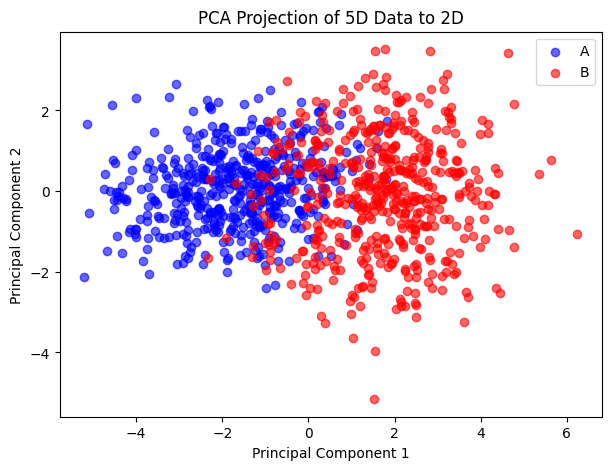

Explained variance by PC1 and PC2: [0.51992967 0.16151537]


In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume df is the DataFrame with f1..f5 and label
X = df[["f1","f2","f3","f4","f5"]].values
y = df["label"].values

# Apply PCA (reduce to 2 dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Make scatter plot
plt.figure(figsize=(7,5))
for label, color in zip(["A", "B"], ["blue", "red"]):
    subset = X_pca[y == label]
    plt.scatter(subset[:,0], subset[:,1], c=color, label=label, alpha=0.6)

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of 5D Data to 2D")
plt.legend()
plt.show()

# Explained variance ratio
print("Explained variance by PC1 and PC2:", pca.explained_variance_ratio_)


##### Analyze the Plots

- Based on your 2D projection, describe the relationship between the two classes.
- Discuss the linear separability of the data. Explain why this type of data structure poses a challenge for simple linear models and would likely require a multi-layer neural network with non-linear activation functions to be classified accurately.


##### __Relationship Between Classes__

- In the 2D PCA scatter plot, Class A (blue) tends to cluster around the origin, while Class B (red) clusters around a shifted region (due to its mean vector [1.5,1.5,1.5,1.5,1.5]).

- However, because both classes share *__overlapping covariance structures, their projected clouds are not fully separated__*. So, there’s an overlap region in the PCA space.

- This means:
  - Many samples from A and B occupy similar regions, especially along dimensions where variance is high.

  - The classes are distinguishable in aggregate but not with a simple, clean split.

##### __Linear Separability__

- Linear separability means: you can draw a straight line (or, in higher dimensions, a hyperplane) that perfectly separates the two classes.
  - In the PCA 2D view, the overlap between clusters indicates that no straight line can perfectly separate them. This results in an impossibility for *linear classifiers* to create boundaries, as they assume a single straight boundary can separate classes
  
  - Even in 5D, the covariance overlap means the classes are intertwined: a single hyperplane won’t cleanly divide A and B.

- Neural networks with nonlinear activations (ReLU, tanh, sigmoid, etc.) can learn curved, flexible decision boundaries. That means:
  - They don't restrict you to simple, linear boundaries. They can curve/warp the overlap to untangle structures
  
  - Example:
    - A first hidden layer could capture correlated patterns (e.g., f1 & f2 strongly linked).
  
    - Later layers could combine features nonlinearly to carve out more complex decision regions.
  
  - This flexibility allows a neural net to outperform a simple linear classifier on data like this, where elliptical clouds overlap in multiple dimensions.

### Excercise 3 - Preparing Real-World Data for a Neural Network

This exercise uses a real dataset from Kaggle. Your task is to perform the necessary preprocessing to make it suitable for a neural network that uses the hyperbolic tangent (tanh) activation function in its hidden layers.

Get the Data: Download the Spaceship Titanic dataset from Kaggle.


In [87]:
train_spaceship = pd.read_csv("spaceship/train.csv")
test_spaceship = pd.read_csv("spaceship/test.csv")
submission_spaceship = pd.read_csv("spaceship/sample_submission.csv")

train_spaceship.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [88]:
import pandas as pd

# Load your dataset
df = pd.read_csv("spaceship/train.csv")

# 1. Count missing values per column
print(df.isna().sum())

# 2. Show percentage of missing values
print((df.isna().mean() * 100).round(2))

# 3. Create a clean summary DataFrame
missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
    "missing_percent": (df.isna().mean() * 100).round(2)
})
print(missing_summary)

# 4. Optionally, show only columns with missing data
print(missing_summary[missing_summary["missing_count"] > 0])


PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
PassengerId     0.00
HomePlanet      2.31
CryoSleep       2.50
Cabin           2.29
Destination     2.09
Age             2.06
VIP             2.34
RoomService     2.08
FoodCourt       2.11
ShoppingMall    2.39
Spa             2.11
VRDeck          2.16
Name            2.30
Transported     0.00
dtype: float64
              missing_count  missing_percent
PassengerId               0             0.00
HomePlanet              201             2.31
CryoSleep               217             2.50
Cabin                   199             2.29
Destination             182             2.09
Age                     179             2.06
VIP                     203             2.34
RoomService             181           

##### Describe the Data:

- Briefly describe the dataset's objective (i.e., what does the Transported column represent?).
  - The dataset's objective is to identify if the passanger was transported to an alternate dimension or not
  - The transported column is the __target column__ which shows if the passanger was or not transported to an alternate dimension. It is a boolean classification of true or false
- List the features and identify which are numerical (e.g., Age, RoomService) and which are categorical (e.g., HomePlanet, Destination).
  - PassengerId: __Unique numerical code__, identifier for each individual passenger
  - Name: __Categorical__, name of passenger
  - HomePlanet: __Categorical__, name of planet where passenger comes from
  - CryoSleep: __Boolean__, shows if passenger was or not in CryoSleep
  - Cabin: __Structured string__, can be split into __categorical__ sub-features. shows cabin where passenger is hosted
  - Destination: __Categorical__, destination of passenger
  - Age: __Numerical__, age of passenger
  - VIP: __Boolean__, shows if passenger is or not a VIP
  - RoomService: __Numerical__, amount spent on room service
  - FoodCourt: __Numerical__, amount spent on foodcourt
  - ShoppingMall: __Numerical__, amount spent on shopping mall
  - Spa: __Numerical__, amount spent on Spa
  - VRDeck: __Numerical__, amount spent on VRDeck
  - Transported: __Boolean__, shows if passenger was or not transported to alternate dimension
- Investigate the dataset for missing values. Which columns have them, and how many?
  - HomePlanet      201
  - CryoSleep       217
  - Cabin           199
  - Destination     182
  - Age             179
  - VIP             203
  - RoomService     181
  - FoodCourt       183
  - ShoppingMall    208
  - Spa             183
  - VRDeck          188
  - Name            200


In [89]:
df["VIP"].value_counts(dropna=False)

VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64

##### Preprocess the Data: 

Your goal is to clean and transform the data so it can be fed into a neural network. The tanh activation function produces outputs in the range [-1, 1], so your input data should be scaled appropriately for stable training.

- Handle Missing Data: Devise and implement a strategy to handle the missing values in all the affected columns. Justify your choices.
    - Median for age: avoids biases towards any particular demographic
    - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: para preços, em caso de falta, assumir valor 0
    - HomePlanet, Destination: Fill as Unknown, as we have no information in regards to the origins and destinations
    - CryoSleep, VIP: As there are more Non-VIP and Non-CryoSleep passengers, assume both values as False
    - Cabin: Assume values as Unknown/0/U, ensuring cabins stay as unknown, impacting analysis the least as possible

In [90]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load
df = pd.read_csv("spaceship/train.csv")

# -----------------------------
# 1) Impute (no inplace on Series)
# -----------------------------
# Numerics
df["Age"] = df["Age"].fillna(df["Age"].median())
for col in ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]:
    df[col] = df[col].fillna(0)

# Categoricals / booleans
df["HomePlanet"] = df["HomePlanet"].fillna("Unknown")
df["Destination"] = df["Destination"].fillna("Unknown")
# Ensure boolean dtype, then fill
df["CryoSleep"] = df["CryoSleep"].astype("boolean").fillna(False)
df["VIP"]       = df["VIP"].astype("boolean").fillna(False)

# Cabin: impute, then split
df["Cabin"] = df["Cabin"].fillna("Unknown/0/U")
cparts = df["Cabin"].str.split("/", expand=True)
cparts.columns = ["Deck", "CabinNum", "Side"]
df = pd.concat([df.drop(columns=["Cabin"]), cparts], axis=1)

# CabinNum -> numeric
df["CabinNum"] = pd.to_numeric(df["CabinNum"], errors="coerce").fillna(0)

# (Optional) split PassengerId into group and index, then drop the raw id
# This avoids leaking ID as a high-cardinality feature.
pid = df["PassengerId"].str.split("_", expand=True)
pid.columns = ["GroupId", "GroupIdx"]
df["GroupId"] = pd.to_numeric(pid["GroupId"], errors="coerce").fillna(0)
df["GroupIdx"] = pd.to_numeric(pid["GroupIdx"], errors="coerce").fillna(0)

# Drop text fields that won’t help a basic NN without NLP
df = df.drop(columns=["Name", "PassengerId"])

# -----------------------------
# 2) Encode categoricals compactly
# -----------------------------
# Keep only small-cardinality categoricals
cat_cols = ["HomePlanet", "Destination", "Deck", "Side"]

# Convert booleans to 0/1 first (then we can map to -1/1 later if desired)
df["CryoSleep"] = df["CryoSleep"].astype("int8")
df["VIP"]       = df["VIP"].astype("int8")

# One-hot encode small-cardinality columns (drop_first to reduce collinearity)
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# -----------------------------
# 3) Scale numerics to [-1, 1] for tanh
# -----------------------------
num_cols = [
    "Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck",
    "CabinNum", "GroupId", "GroupIdx"
]

scaler = MinMaxScaler(feature_range=(-1, 1))
df[num_cols] = scaler.fit_transform(df[num_cols])

# Optionally map binary 0/1 columns to -1/1 (helps symmetry for tanh)
# Here, CryoSleep and VIP are binary columns:
for bcol in ["CryoSleep", "VIP"]:
    df[bcol] = df[bcol].map({0: -1.0, 1: 1.0})

# Finally, ensure float32 for NN input tensors
for col in df.columns:
    if df[col].dtype == "bool":
        df[col] = df[col].astype("float32")  # True/False -> 1.0/0.0 (if any remain)
    elif pd.api.types.is_integer_dtype(df[col]) or pd.api.types.is_float_dtype(df[col]):
        df[col] = df[col].astype("float32")

print(df.shape, "columns:", len(df.columns))
print(df.head(3))


(8693, 28) columns: 28
   CryoSleep       Age  VIP  RoomService  FoodCourt  ShoppingMall      Spa  \
0       -1.0 -0.012658 -1.0    -1.000000  -1.000000     -1.000000 -1.00000   
1       -1.0 -0.392405 -1.0    -0.984784  -0.999396     -0.997872 -0.95100   
2       -1.0  0.468354  1.0    -0.993997  -0.760105     -1.000000 -0.40066   

     VRDeck  Transported  CabinNum  ...  Deck_B  Deck_C  Deck_D  Deck_E  \
0 -1.000000          0.0      -1.0  ...     1.0     0.0     0.0     0.0   
1 -0.996354          1.0      -1.0  ...     0.0     0.0     0.0     0.0   
2 -0.995939          0.0      -1.0  ...     0.0     0.0     0.0     0.0   

   Deck_F  Deck_G  Deck_T  Deck_Unknown  Side_S  Side_U  
0     0.0     0.0     0.0           0.0     0.0     0.0  
1     1.0     0.0     0.0           0.0     1.0     0.0  
2     0.0     0.0     0.0           0.0     1.0     0.0  

[3 rows x 28 columns]


- Encode Categorical Features: Convert categorical columns like HomePlanet, CryoSleep, and Destination into a numerical format. One-hot encoding is a good choice.


In [92]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load dataset
df = pd.read_csv("spaceship/train.csv")

# Categorical columns
categorical_cols = ["HomePlanet", "CryoSleep", "Destination"]

# Handle missing values FIRST, then cast to string so types are uniform
df[categorical_cols] = df[categorical_cols].fillna("Unknown").astype("string")

# Initialize OneHotEncoder (handle_unknown is good practice for train/test mismatch)
try:
    encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    encoder = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)        # sklearn < 1.2

# Fit + transform
encoded_array = encoder.fit_transform(df[categorical_cols])

# Column names for encoded features
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Build final DataFrame: original minus the raw cats + encoded dummies
df_encoded = pd.concat(
    [df.drop(columns=categorical_cols).reset_index(drop=True),
     pd.DataFrame(encoded_array, columns=encoded_cols, dtype=float)],
    axis=1
)

print(df_encoded.head())
print("Number of columns after encoding:", df_encoded.shape[1])


  PassengerId  Cabin   Age    VIP  RoomService  FoodCourt  ShoppingMall  \
0     0001_01  B/0/P  39.0  False          0.0        0.0           0.0   
1     0002_01  F/0/S  24.0  False        109.0        9.0          25.0   
2     0003_01  A/0/S  58.0   True         43.0     3576.0           0.0   
3     0003_02  A/0/S  33.0  False          0.0     1283.0         371.0   
4     0004_01  F/1/S  16.0  False        303.0       70.0         151.0   

      Spa  VRDeck               Name  Transported  HomePlanet_Europa  \
0     0.0     0.0    Maham Ofracculy        False                1.0   
1   549.0    44.0       Juanna Vines         True                0.0   
2  6715.0    49.0      Altark Susent        False                1.0   
3  3329.0   193.0       Solam Susent        False                1.0   
4   565.0     2.0  Willy Santantines         True                0.0   

   HomePlanet_Mars  HomePlanet_Unknown  CryoSleep_True  CryoSleep_Unknown  \
0              0.0                 0.0 

- Normalize/Standardize Numerical Features: Scale the numerical columns (e.g., Age, RoomService, etc.). Since the tanh activation function is centered at zero and outputs values in [-1, 1], Standardization (to mean 0, std 1) or Normalization to a [-1, 1] range are excellent choices. Implement one and explain why it is a good practice for training neural networks with this activation function.

  - Different features may live on very different scales (Age ~ 0–80, RoomService ~ 0–10,000).

  - Features with large magnitudes dominate the loss surface, while smaller ones contribute very little. As such, an imbalance is presented in learning.

  - Normalization has ranges between [-1, 1]. It’s steepest around 0 and flattens near the extremes.

  - It is good practice because:

    - Keeps all features comparable: avoids features dominating over others.

    - Matches tanh’s natural range: inputs in [-1,1] align perfectly with the output scale.

    - Faster convergence: optimizers like SGD, Adam work better with well-scaled features.

    - Improves generalization: network learns smoother decision boundaries.

In [93]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("spaceship/train.csv")

# Numerical columns
num_cols = ["Age","RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]

# Handle missing values before scaling
df["Age"] = df["Age"].fillna(df["Age"].median())
for col in ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]:
    df[col] = df[col].fillna(0)

# Apply MinMax scaling to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1,1))
df[num_cols] = scaler.fit_transform(df[num_cols])

print(df[num_cols].head())


        Age  RoomService  FoodCourt  ShoppingMall       Spa    VRDeck
0 -0.012658    -1.000000  -1.000000     -1.000000 -1.000000 -1.000000
1 -0.392405    -0.984784  -0.999396     -0.997872 -0.951000 -0.996354
2  0.468354    -0.993997  -0.760105     -1.000000 -0.400660 -0.995939
3 -0.164557    -1.000000  -0.913930     -0.968415 -0.702874 -0.984005
4 -0.594937    -0.957702  -0.995304     -0.987145 -0.949572 -0.999834


##### Visualize the Results:

Create histograms for one or two numerical features (like FoodCourt or Age) before and after scaling to show the effect of your transformation.


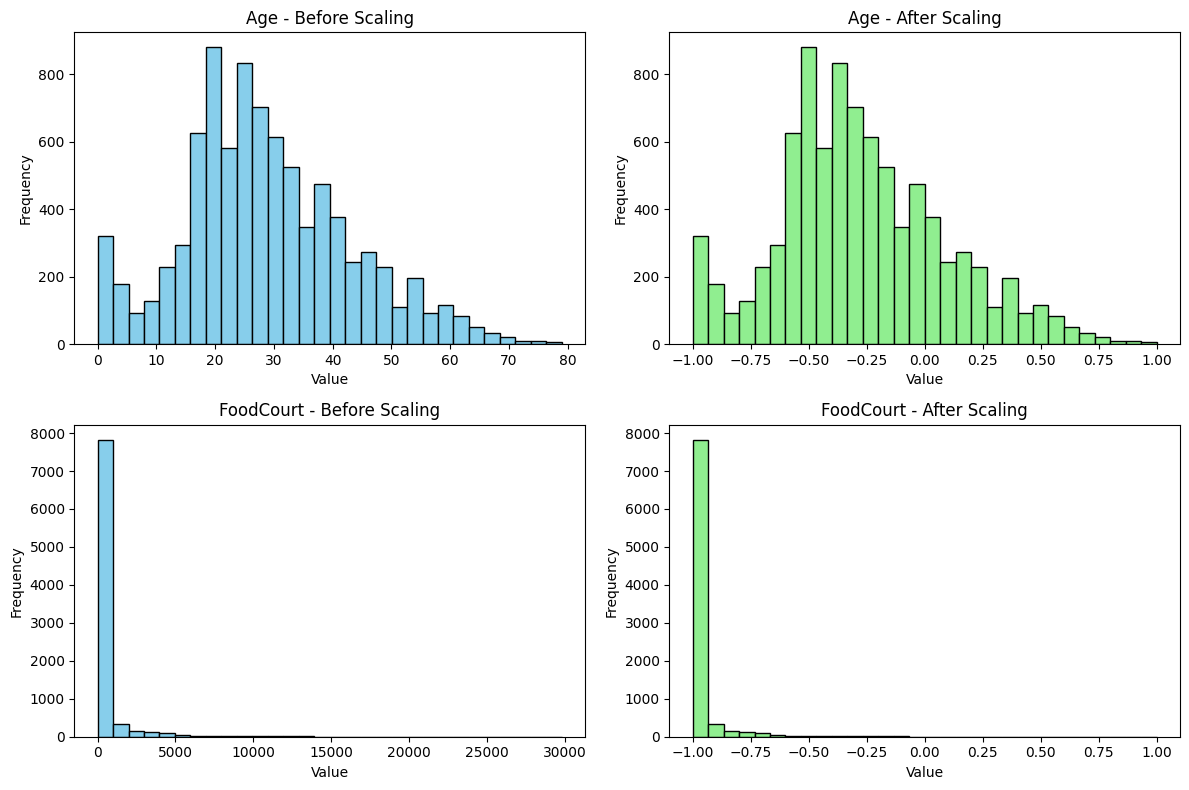

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load dataset (adjust path if needed)
df_raw = pd.read_csv("spaceship/train.csv")

# Pick numerical features
num_cols = ["Age", "FoodCourt"]

# Handle missing values
df_raw["Age"] = df_raw["Age"].fillna(df_raw["Age"].median())
df_raw["FoodCourt"] = df_raw["FoodCourt"].fillna(0)

# Scale with MinMaxScaler to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = df_raw.copy()
df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])

# Plot histograms before and after scaling
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Age before and after
axes[0,0].hist(df_raw["Age"], bins=30, color="skyblue", edgecolor="black")
axes[0,0].set_title("Age - Before Scaling")
axes[0,1].hist(df_scaled["Age"], bins=30, color="lightgreen", edgecolor="black")
axes[0,1].set_title("Age - After Scaling")

# FoodCourt before and after
axes[1,0].hist(df_raw["FoodCourt"], bins=30, color="skyblue", edgecolor="black")
axes[1,0].set_title("FoodCourt - Before Scaling")
axes[1,1].hist(df_scaled["FoodCourt"], bins=30, color="lightgreen", edgecolor="black")
axes[1,1].set_title("FoodCourt - After Scaling")

for ax in axes.flat:
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()
